In [1]:
import calliope
import pandas as pd
from building import Building
import geopandas as gpd
import gc
import os
import matplotlib.pyplot as plt
import glob
import warnings
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase

In [2]:
calliope.set_log_verbosity(verbosity='error', include_solver_output=False, capture_warnings=False)
# disable the warnings
warnings.filterwarnings('ignore')

In [3]:
# plot setting
# set style of plots
plt.rcParams['font.family'] = 'Roboto'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['legend.loc'] = 'lower center'
plt.rcParams['legend.frameon'] = False
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titley'] = 1.03
plt.rcParams['figure.subplot.left'] = 0.08
plt.rcParams['figure.subplot.right'] = 0.95
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.width'] = 2  # setting the x-axis tick width globally
plt.rcParams['ytick.major.width'] = 2 # setting the y-axis tick width globally
# set fig size
plt.rcParams['figure.figsize'] = (12, 8)

In [4]:
# define a function that optimize one single building
def get_building_model(building_name, building_scenario_folder, yaml_path, store_folder,
                       building_status: pd.Series = None, flatten_spikes=False, flatten_percentile=0.98, 
                       to_lp=False, to_yaml=False, 
                       obj='cost',
                       emission_constraint=None):
    building = Building(building_name, building_scenario_folder)
    if flatten_spikes:
        building.flatten_spikes_demand(percentile=flatten_percentile) # flatten the demand spikes
    dict_timeseries_df = {'demand_el': building.app,
                          'demand_sh': building.sh,
                          'demand_dhw': building.dhw,
                          'demand_sc': building.sc,
                          'supply_PV': building.pv_intensity,
                          'supply_PVT_e': building.pvt_e_intensity,
                          'supply_PVT_h': building.pvt_h_relative_intensity,
                          'supply_SCFP': building.scfp_intensity
                          }
    # modify the building_specific_config to match the building's status
    building_specific_config: calliope.AttrDict = calliope.AttrDict.from_yaml(yaml_path)
    building_specific_config.set_key(key='locations.Building.available_area', value=building.area)
    print('the area of building '+building.name+' is '+str(building.area)+' m2')
    building_sub_dict = building_specific_config['locations'].pop('Building')
    building_specific_config['locations'][building.name] = building_sub_dict
    
    # update geothermal storage max capacity
    building_specific_config.set_key(key=f'locations.{building.name}.techs.geothermal_boreholes.constraints.energy_cap_max',
                                     value=(building.area+400)*0.1) # assume 100W/m2 max yield
    if building_status is not None:
        # if building is not in district heating area, delete the district heating technologies keys
        if not building_status['is_disheat']:
            building_specific_config.del_key(f'locations.{building.name}.techs.DHDC_small_heat')
            building_specific_config.del_key(f'locations.{building.name}.techs.DHDC_medium_heat')
            building_specific_config.del_key(f'locations.{building.name}.techs.DHDC_large_heat')
            
        # if building is not rebuilt, set GSHP and ASHP costs higher
        if building_status['is_new']:
            if building_status['is_rebuilt']: # rebuilt, so everything is possible and price is normal
                pass
            else: # renovated, can do GSHP and ASHP but price higher
                if building_status['already_GSHP']: # already has GSHP, only need to set ASHP price higher, and gsHP price to 0
                    building_specific_config.set_key(f'locations.{building.name}.techs.GSHP_heat.costs.monetary.purchase', 0)
                    building_specific_config.set_key(f'locations.{building.name}.techs.GSHP_heat.costs.monetary.energy_cap', 0)
                    
                    building_specific_config.set_key(f'locations.{building.name}.techs.ASHP.costs.monetary.purchase', 18086)
                    building_specific_config.set_key(f'locations.{building.name}.techs.ASHP.costs.monetary.energy_cap', 1360)
                    building_specific_config.set_key(f'locations.{building.name}.techs.ASHP_DHW.costs.monetary.purchase', 18086)
                    building_specific_config.set_key(f'locations.{building.name}.techs.ASHP_DHW.costs.monetary.energy_cap', 1360)
                elif building_status['already_ASHP']: # ASHP for heating no cost; but ASHP for DHW higher; also GSHP higher
                    building_specific_config.set_key(f'locations.{building.name}.techs.GSHP_heat.costs.monetary.purchase', 39934)
                    building_specific_config.set_key(f'locations.{building.name}.techs.GSHP_heat.costs.monetary.energy_cap', 1316)
                    
                    building_specific_config.set_key(f'locations.{building.name}.techs.ASHP.costs.monetary.purchase', 0)
                    building_specific_config.set_key(f'locations.{building.name}.techs.ASHP.costs.monetary.energy_cap', 0)
                    building_specific_config.set_key(f'locations.{building.name}.techs.ASHP_DHW.costs.monetary.purchase', 18086)
                    building_specific_config.set_key(f'locations.{building.name}.techs.ASHP_DHW.costs.monetary.energy_cap', 1360)
                else: # no GSHP and no ASHP, set both to higher price
                    building_specific_config.set_key(f'locations.{building.name}.techs.GSHP_heat.costs.monetary.purchase', 39934)
                    building_specific_config.set_key(f'locations.{building.name}.techs.GSHP_heat.costs.monetary.energy_cap', 1316)
                    
                    building_specific_config.set_key(f'locations.{building.name}.techs.ASHP.costs.monetary.purchase', 18086)
                    building_specific_config.set_key(f'locations.{building.name}.techs.ASHP.costs.monetary.energy_cap', 1360)
                    building_specific_config.set_key(f'locations.{building.name}.techs.ASHP_DHW.costs.monetary.purchase', 18086)
                    building_specific_config.set_key(f'locations.{building.name}.techs.ASHP_DHW.costs.monetary.energy_cap', 1360)
        else: # not new, so no new GSHP but new ASHP allowed; however if they are already with GSHP or ASHP, then no corresponding cost is applied
            if building_status['already_GSHP']:
                building_specific_config.set_key(f'locations.{building.name}.techs.GSHP_heat.costs.monetary.purchase', 0)
                building_specific_config.set_key(f'locations.{building.name}.techs.GSHP_heat.costs.monetary.energy_cap', 0)
                
                building_specific_config.set_key(f'locations.{building.name}.techs.ASHP.costs.monetary.purchase', 18086)
                building_specific_config.set_key(f'locations.{building.name}.techs.ASHP.costs.monetary.energy_cap', 1360)
                building_specific_config.set_key(f'locations.{building.name}.techs.ASHP_DHW.costs.monetary.purchase', 18086)
                building_specific_config.set_key(f'locations.{building.name}.techs.ASHP_DHW.costs.monetary.energy_cap', 1360)
            elif building_status['already_ASHP']: # no previous GSHP, so delete GSHP keys; 
                building_specific_config.del_key(f'locations.{building.name}.techs.GSHP_heat')
                building_specific_config.del_key(f'locations.{building.name}.techs.GSHP_cooling')
                building_specific_config.del_key(f'locations.{building.name}.techs.geothermal_boreholes')
                
                building_specific_config.set_key(f'locations.{building.name}.techs.ASHP.costs.monetary.purchase', 0)
                building_specific_config.set_key(f'locations.{building.name}.techs.ASHP.costs.monetary.energy_cap', 0)
                building_specific_config.set_key(f'locations.{building.name}.techs.ASHP_DHW.costs.monetary.purchase', 18086)
                building_specific_config.set_key(f'locations.{building.name}.techs.ASHP_DHW.costs.monetary.energy_cap', 1360)
            else: # no previous GSHP and no previous ASHP, so delete GSHP keys and higher ASHP keys
                building_specific_config.del_key(f'locations.{building.name}.techs.GSHP_heat')
                building_specific_config.del_key(f'locations.{building.name}.techs.GSHP_cooling')
                building_specific_config.del_key(f'locations.{building.name}.techs.geothermal_boreholes')
                
                building_specific_config.set_key(f'locations.{building.name}.techs.ASHP.costs.monetary.purchase', 18086)
                building_specific_config.set_key(f'locations.{building.name}.techs.ASHP.costs.monetary.energy_cap', 1360)
                building_specific_config.set_key(f'locations.{building.name}.techs.ASHP_DHW.costs.monetary.purchase', 18086)
                building_specific_config.set_key(f'locations.{building.name}.techs.ASHP_DHW.costs.monetary.energy_cap', 1360)

        # set the wood energy cap max to be 0.5W/m2 times building area +400 m2
        building_specific_config.set_key(key=f'locations.{building.name}.techs.wood_supply.constraints.energy_cap_max', value=(building.area+400)*0.5*0.001)
    # # test: delete ASHP
    # building_specific_config.del_key(f'locations.{building.name}.techs.ASHP')
    
    # if emission constraint is not None, add it to the building_specific_config
    if emission_constraint is not None:
        building_specific_config.set_key(key='group_constraints.systemwide_co2_cap.cost_max.co2', value=emission_constraint)
    
    # if obj is cost, set the objective to be cost; if obj is emission, set the objective to be emission
    if obj == 'cost':
        building_specific_config.set_key(key='run.objective_options.cost_class.monetary', value=1)
        building_specific_config.set_key(key='run.objective_options.cost_class.co2', value=0)
    elif obj == 'emission':
        building_specific_config.set_key(key='run.objective_options.cost_class.monetary', value=0)
        building_specific_config.set_key(key='run.objective_options.cost_class.co2', value=1)
    else:
        raise ValueError('obj must be either cost or emission')
    # print current objective setting
    print(building_specific_config.get_key('run.objective_options.cost_class'))
    model = calliope.Model(building_specific_config, timeseries_dataframes=dict_timeseries_df)
    if to_lp:
        model.to_lp(store_folder+'/'+building.name+'.lp')
    if to_yaml:
        model.save_commented_model_yaml(store_folder+'/'+building.name+'.yaml')
    return model
    

In [5]:
# define a function that finds the pareto front of one building regarding cost and emission
def get_pareto_front(epsilon:int, building_name, building_scenario_folder, yaml_path, store_folder,
                     building_status: pd.Series = None, flatten_spikes=False, flatten_percentile=0.98,
                     to_lp=False, to_yaml=False):
    df_pareto = pd.DataFrame(columns=['cost', 'emission'], index=range(epsilon+2))
    # read yaml file and get the list of technologies
    tech_list = calliope.AttrDict.from_yaml(yaml_path).get_key(f'locations.Building.techs').keys()
    df_tech_cap_pareto = pd.DataFrame(columns=tech_list, index=range(epsilon+2))
    # first get the emission-optimal solution
    model_emission = get_building_model(building_name=building_name, building_scenario_folder=building_scenario_folder, 
                                        yaml_path=yaml_path, store_folder=store_folder, 
                                        building_status=building_status, flatten_spikes=flatten_spikes, 
                                        flatten_percentile=flatten_percentile, to_lp=to_lp, to_yaml=to_yaml, 
                                        obj='emission')
    model_emission.run()
    model_emission.to_netcdf(path=store_folder + '/' + building_name+'_emission.nc')
    print('emission is done')
    # store the cost and emission in df_pareto
    df_emission = model_emission.get_formatted_array('cost').sel(locs=building_name).to_pandas().transpose().sum(axis=0)
    # add the cost and emission to df_pareto
    df_pareto.loc[0] = [df_emission['monetary'], df_emission['co2']]
    # store the technology capacities in df_tech_cap_pareto
    df_tech_cap_pareto.loc[0] = model_emission.get_formatted_array('energy_cap').to_pandas().iloc[0]
    
    # then get the cost-optimal solution
    model_cost = get_building_model(building_name=building_name, building_scenario_folder=building_scenario_folder, 
                                    yaml_path=yaml_path, store_folder=store_folder, 
                                    building_status=building_status, flatten_spikes=flatten_spikes, 
                                    flatten_percentile=flatten_percentile, to_lp=to_lp, to_yaml=to_yaml, 
                                    obj='cost')
    # run model cost, and find both cost and emission of this result
    model_cost.run()
    model_cost.to_netcdf(path=store_folder  + '/' + building_name+'_cost.nc')
    print('cost is done')
    # store the cost and emission in df_pareto
    # add epsilon name as row index, start with epsilon_0
    df_cost: pd.DataFrame = model_cost.get_formatted_array('cost').sel(locs=building_name).to_pandas().transpose().sum(axis=0) # first column co2, second column monetary
    # add the cost and emission to df_pareto
    df_pareto.loc[epsilon+1] = [df_cost['monetary'], df_cost['co2']]
    # store the technology capacities in df_tech_cap_pareto
    df_tech_cap_pareto.loc[epsilon+1] = model_cost.get_formatted_array('energy_cap').to_pandas().iloc[0]
    # based on epsilon numbers, create empty rows in df_pareto for further filling

    # then get the epsilon-optimal solution
    # first find out min and max emission, and epsilon emissions are evenly distributed between them
    # if cost and emission optimal have the same emission, then there's no pareto front
    if df_cost['co2'] <= df_emission['co2']:
        print('cost-optimal and emission-optimal have the same emission, no pareto front')
        return df_pareto
    else:
        emission_max =df_cost['co2']
        emission_min =df_emission['co2']
        # calculate the interval between two emissions
        interval = (emission_max - emission_min) / (epsilon+1)
        # for each epsilon, get the epsilon-optimal solution
        for i in range(1, epsilon+1):
            print(f'starting epsilon {i}')
            # set the emission constraint to be emission_min + i * interval
            emission_constraint = emission_min + i * interval
            model_epsilon = get_building_model(building_name=building_name, building_scenario_folder=building_scenario_folder, 
                                               yaml_path=yaml_path, store_folder=store_folder, 
                                               building_status=building_status, flatten_spikes=flatten_spikes, 
                                               flatten_percentile=flatten_percentile, to_lp=to_lp, to_yaml=to_yaml, 
                                               obj='cost', emission_constraint=emission_constraint)
            model_epsilon.run()
            model_epsilon.to_netcdf(path=store_folder  + '/' + building_name + f'_epsilon_{i}.nc')
            print(f'epsilon {i} is done')
            # store the cost and emission in df_pareto
            df_epsilon = model_epsilon.get_formatted_array('cost').sel(locs=building_name).to_pandas().transpose().sum(axis=0)
            # add the cost and emission to df_pareto
            df_pareto.loc[i] = [df_epsilon['monetary'], df_epsilon['co2']]
            # store the technology capacities in df_tech_cap_pareto
            df_tech_cap_pareto.loc[i] = model_epsilon.get_formatted_array('energy_cap').to_pandas().iloc[0]
            
        df_pareto = df_pareto.merge(df_tech_cap_pareto, left_index=True, right_index=True)
        df_pareto = df_pareto.astype({'cost': float, 'emission': float})
        return df_pareto

In [6]:
def get_gdf_from_dbf(dbf_path):
    gdf = gpd.read_file(dbf_path)
    gdf.drop(columns=["geometry"], inplace=True)
    df = pd.DataFrame()
    df = pd.concat([df, gdf], axis=1)
    df.set_index("Name", inplace=True)
    return df

In [7]:
scenario_folder = r'C:\Users\wangy\OneDrive\ETHY2FW\IDP_Personal\CEA\2050 w3'
zone_gdf = gpd.read_file(scenario_folder+r'\inputs\building-geometry\zone.shp')
zone_gdf.index = zone_gdf['Name']
# create a new df using only the columns we need
zone_df = pd.DataFrame()
zone_df['Name'] = zone_gdf['Name']
zone_df.index = zone_df['Name']
# delete the Name column in zone_df
zone_df = zone_df.drop(columns='Name')
typology_gdf = gpd.read_file(scenario_folder+r'\inputs\building-properties\typology.dbf')
typology_gdf.index = typology_gdf['Name']
zone_df = pd.concat([zone_df, typology_gdf['YEAR'], ], axis=1)

In [8]:
zone_gdf['area'] = zone_gdf['geometry'].area
zone_df = pd.concat([zone_df, zone_gdf['area'], zone_gdf['floors_ag']], axis=1)
zone_df.dtypes

YEAR           int64
area         float64
floors_ag      int64
dtype: object

In [9]:
# read typology file 
# read the csv file containing if the building is inside district area
district_df = pd.read_csv(scenario_folder+r'\inputs\is_disheat.csv', index_col=0)
# merge the two df
zone_df = zone_df.merge(district_df, left_index=True, right_index=True)
# read the csv file containing if building is rebuilt
rebuild_df = pd.read_csv(scenario_folder+r'\inputs\Rebuild.csv', index_col=0)
# merge the two df, but since the zone_df has more columns, if rebuild_df doesn't contain some building, set the value to 0
zone_df = zone_df.merge(rebuild_df, left_index=True, right_index=True, how='left').fillna(0)
# read the csv file containing if the building is renovated
renovate_df = pd.read_csv(scenario_folder+r'\inputs\Renovation.csv', index_col=0)
# merge the two df, but since the zone_df has more columns, if renovate_df doesn't contain some building, set the value to 0
zone_df = zone_df.merge(renovate_df, left_index=True, right_index=True, how='left').fillna(0)
# read dbf file containing current building systems
current_system_df = gpd.read_file(r"C:\Users\wangy\OneDrive\ETHY2FW\IDP_Personal\CEA\2023 Baseline\inputs\building-properties\supply_systems.dbf")
# leave only the type_hs column
current_system_df = current_system_df[['Name', 'type_hs']]
current_system_df.index = current_system_df['Name']
current_system_df = current_system_df.drop(columns='Name')
# merge the two df, but since the zone_df has more columns
zone_df = zone_df.merge(current_system_df, left_index=True, right_index=True, how='left')

In [10]:
# add indicating columns to guide adjusting AttrDict based on building's status
zone_df['is_disheat'] = zone_df['DisHeat'].astype(bool)
zone_df['is_rebuilt'] = zone_df['Rebuild'].astype(bool)
zone_df['is_renovated'] = zone_df['Renovation'].astype(bool)
zone_df['is_new'] = ~zone_df['is_rebuilt'] & ~zone_df['is_renovated']
zone_df['already_GSHP'] = zone_df['type_hs'] == 'SUPPLY_HEATING_AS6'
zone_df['already_ASHP'] = zone_df['type_hs'] == 'SUPPLY_HEATING_AS7'
zone_df['no_heat'] = zone_df['type_hs'] == 'SUPPLY_HEATING_AS0'

In [11]:
# get all dbfs from the following subfolder
dbf_folder = scenario_folder + r"\inputs\building-properties"
dbf_files = os.listdir(dbf_folder)
for file in dbf_files:
    if file.endswith(".dbf"):
        dbf_path = dbf_folder + "\\" + file
        df = get_gdf_from_dbf(dbf_path)
        # set the prefix of the column name to the name of the dbf file
        df.columns = [file[:-4] + "_" + col for col in df.columns]
        zone_df = pd.concat([zone_df, df], axis=1)

In [12]:
# iterate through the zone_df to create the building objects and store them in a list
building_list = []
store_folder = './pareto_no_wood'
# check if building's name is already stored in subfolder result_per_building; if not, add it to the list
for index, row in zone_df.iterrows():
    building_name = index
    if building_name+'_pareto.csv' not in os.listdir(store_folder):
        building_list.append(building_name)
    else:
        print(building_name+' is already done')

B162953 is already done
B162948 is already done
B162947 is already done
B162917 is already done
B2365661 is already done
B162952 is already done
B162935 is already done
B162946 is already done
B302024523 is already done
B302024524 is already done
B162920 is already done
B162916 is already done
B302022562 is already done
B162581 is already done
B302022561 is already done
B162585 is already done
B162579 is already done
B162578 is already done
B162396 is already done
B162831 is already done
B162482 is already done
B162404 is already done
B162446 is already done
B162493 is already done
B162930 is already done
B162327 is already done
B162510 is already done
B2365747 is already done
B302034411 is already done
B302032606 is already done
B302030812 is already done
B162590 is already done
B2365703 is already done
B302030808 is already done
B162495 is already done
B162416 is already done
B162605 is already done
B162834 is already done
B162420 is already done
B302034645 is already done
B302065793

In [28]:
test_building_list = [
    # 'B302030807',
                      # 'B302030808', 'B302030809', 'B302030810', 'B302030811', 'B302030812', 'B302030813'
                      ]

In [29]:
# iterate through the zone_df get pareto front for each building and store output in a dictionary
for idx, row in zone_df.iterrows():
    # if building already in building_list, skip it
    if idx not in building_list:
        continue
        
    # if building doesn't need heating, skip it
    if row['no_heat']:
        print(idx+' doesn\'t need heating')
        continue
        
    # # if building not having GSHP, skip it
    # if not row['already_GSHP']:
    #     print(idx+' doesn\'t have GSHP')
    #     continue
    
    # # if building not in test_building_list, skip it
    # if idx not in test_building_list:
    #     continue
    
    # if building is not in district heating area, skip it
    df_pareto = get_pareto_front(epsilon=3, building_name=idx, building_scenario_folder=scenario_folder, 
                                                 yaml_path='./data/technology/techs_plot8.yml', store_folder=store_folder,
                                                 building_status=zone_df.loc[idx], flatten_spikes=True, flatten_percentile=0.98, 
                                                 to_lp=False, to_yaml=False)
    # save the df_pareto as csv
    df_pareto.to_csv(store_folder+'/'+idx+'_pareto.csv')
    del df_pareto
    print(idx+' is done')
    # clean up the rest of the memory
    gc.collect()

B302011886 doesn't need heating
B302012803 doesn't need heating
B302024094 doesn't need heating
B302013071 doesn't need heating
B302024327 doesn't need heating
B302011676 doesn't need heating
B302060757 doesn't need heating
B302024344 doesn't need heating
B302011740 doesn't need heating
B302024101 doesn't need heating
B302011894 doesn't need heating
B302011958 doesn't need heating
B302024497 doesn't need heating
B302012074 doesn't need heating
B302023896 doesn't need heating
B302019762 doesn't need heating
B302024165 doesn't need heating
B302024143 doesn't need heating
B302012488 doesn't need heating
B302011910 doesn't need heating
B302023917 doesn't need heating
B302021222 doesn't need heating
B302011957 doesn't need heating
B302060601 doesn't need heating
B302012080 doesn't need heating
B302024335 doesn't need heating
B302011995 doesn't need heating
B302012558 doesn't need heating
B302024134 doesn't need heating
B302012555 doesn't need heating
B302024146 doesn't need heating
B3020124

## Plotting

In [23]:
# calculate the coefficient of variation of each technology choice for each building and store them in a dataframe; in the end plot a bar chart with error bars for each technology in this dataframe.
# the dataframe should have columns as technology names, and rows as building names
# first define the dataframe column from one of the files in the folder;
# then iterate through the rest of the files and add the data to the dataframe
ls_csv = []
for csv in os.listdir(store_folder):
    if not csv.endswith('.csv'):
        continue
    ls_csv.append(csv)

for idx, csv in enumerate(ls_csv):
    # if the dataframe doesn't exist before, then define its columns with the first file
    if idx == 0:
        df_example = pd.read_csv('./pareto_no_wood/'+csv, index_col=0, nrows=1)
        # add the first level index to be building name
        df_example.index = pd.MultiIndex.from_tuples([(csv, i) for i in df_example.index], names=['building', 'epsilon'])
        df_tech_cap = pd.DataFrame(columns=df_example.columns, index=df_example.index)
        df_tech_cap = df_tech_cap.dropna(how='all')

    building_sizing = pd.read_csv(store_folder+'/'+csv, index_col=0)
    # # calculate the coefficient of variation for each technology
    # df_tech_cap.loc[csv[:-10]] = building_sizing.std() / building_sizing.mean()
    building_name = csv[:-11]
    # if wood_boiler_DHW is 2000 at emission optimal (the first row), then it's oversized, change it to the DHW demand
    if building_sizing.loc[0, 'wood_boiler_DHW'] == 2000:
        building_sizing.loc[0, 'wood_boiler_DHW'] = building_sizing.loc[4, 'demand_hot_water']
        building_sizing.loc[0, 'DHDC_small_heat'] = 0
        building_sizing.loc[0, 'DHDC_medium_heat'] = 0
        building_sizing.loc[0, 'DHDC_large_heat'] = 0
    # if wood_boiler_heat is 2000 at emission optimal (the first row), then it's oversized, change it to the SH demand
    if building_sizing.loc[0, 'wood_boiler_heat'] == 2000:
        building_sizing.loc[0, 'wood_boiler_heat'] = building_sizing.loc[4, 'demand_space_heating']
        
    building_area = zone_df.loc[building_name, 'area'] * zone_df.loc[building_name, 'floors_ag']
    # calculate the sizing per m2
    building_sizing_per_m2 = building_sizing.fillna(0) / building_area
    # add the first level index to be building name
    building_sizing_per_m2.reset_index(drop=True, inplace=True)
    building_sizing_per_m2.index = pd.MultiIndex.from_product([[building_name], building_sizing_per_m2.index], names=['building', 'epsilon'])
    
    # add the building_sizing_per_m2 to df_tech_cap to the bottom, but keep the multiindex
    df_tech_cap = pd.concat([df_tech_cap, building_sizing_per_m2], axis=0)


In [24]:
# check if df_tech_cap has two levels of index
df_tech_cap.index.nlevels
# filter buildings that have GSHP. Refer to zone_df['already_GSHP'] for the boolean value, and refresh the df_tech_cap
df_tech_cap = df_tech_cap[df_tech_cap.index.get_level_values('building').isin(zone_df[zone_df['already_GSHP']].index)]

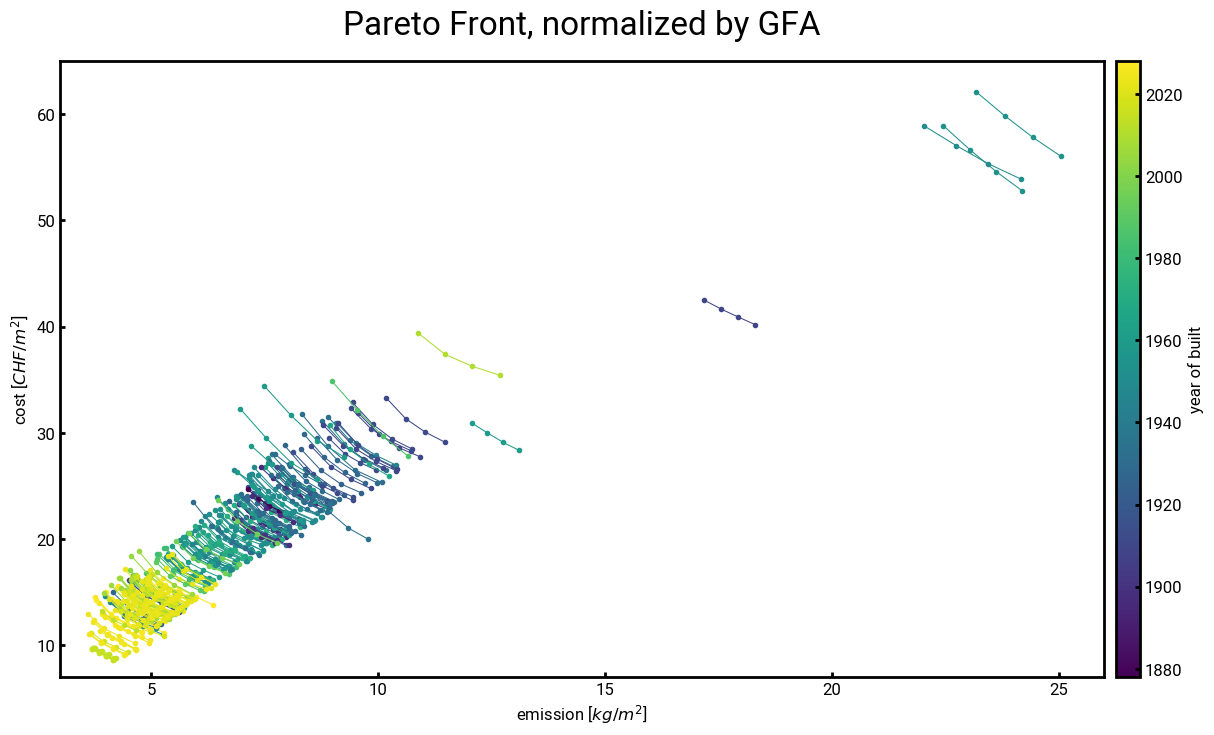

In [38]:
year_min = zone_df['YEAR'].min()
year_max = zone_df['YEAR'].max()
year_norm = mcolors.Normalize(vmin=year_min, vmax=year_max)
colormap = plt.cm.get_cmap('viridis')
for building_name in df_tech_cap.index.get_level_values('building').unique():
    # get the df_pareto for this building
    df_pareto = df_tech_cap.loc[building_name]
    # find the building area
    building_area = zone_df.loc[building_name, 'area'] * zone_df.loc[building_name, 'floors_ag']
    # plot the pareto front, and matching the curve's color in colormap by building's year
    building_year = zone_df.loc[building_name, 'YEAR']
    building_color = colormap(year_norm(building_year))
    # ignore the mission optimal point which is the first point
    plt.plot(df_pareto['emission'].iloc[1:], 
             df_pareto['cost'].iloc[1:], 
             label=building_name, marker='.', color=building_color, linewidth=0.75)
    
plt.ylabel('cost [$CHF/m^2$]')
plt.xlabel('emission [$kg/m^2$]')
plt.title('Pareto Front, normalized by GFA', fontsize=24)
plt.ylim(7, 65)
plt.xlim(3, 26)
# plt.xlim(1.5, 13)
# plt.ylim(0, 50)
# create a colorbar next to the plot, with the same height as the plot box
cax = plt.axes([0.96, 0.11, 0.02, 0.77])
cbar = ColorbarBase(cax, cmap=colormap, norm=year_norm)
# label the building year on the left of the colorbar
cbar.ax.set_ylabel('year of built')
plt.savefig(r'C:\Users\wangy\polybox - Yiqiao Wang (yiqwang@student.ethz.ch)@polybox.ethz.ch\Final Report\Graphics\ParetoFront_{}.pdf'.format(store_folder[9:]), dpi=300, bbox_inches='tight')
plt.show()

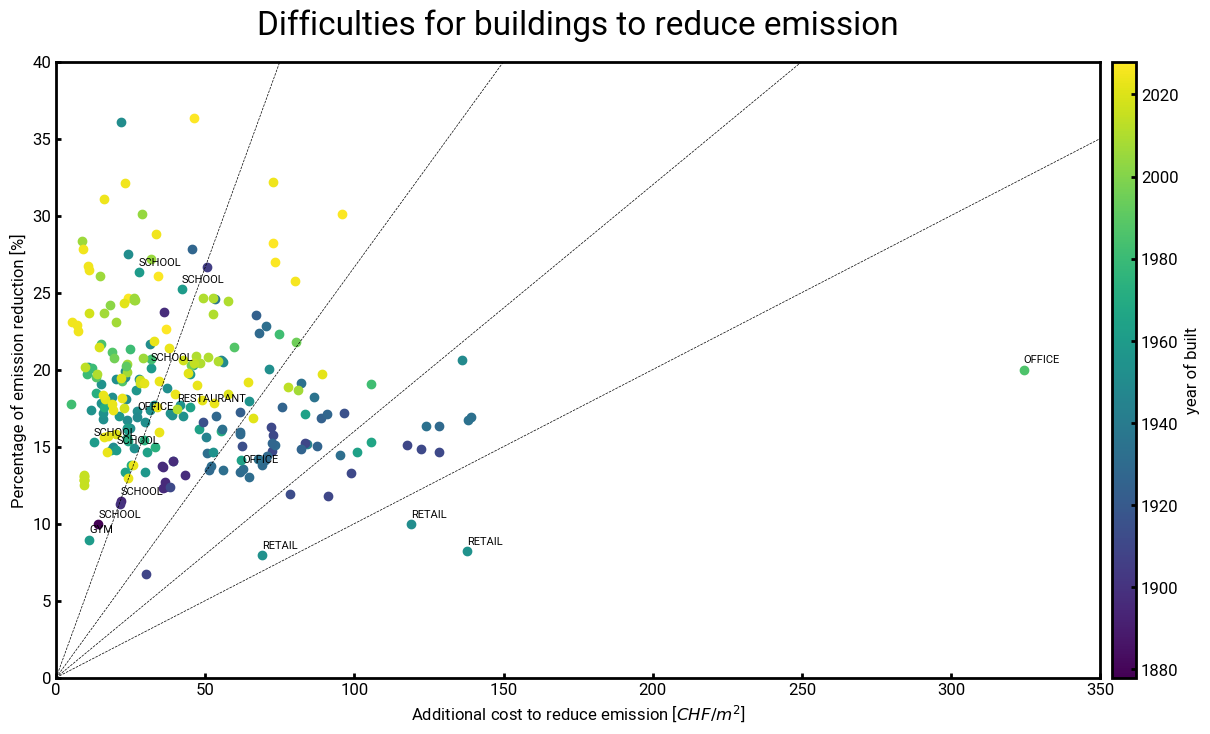

In [49]:
for building_name in df_tech_cap.index.get_level_values('building').unique():
    # get the df_pareto for this building
    df_pareto = df_tech_cap.loc[building_name]
    # the first point is emission minimal, thus cost maximal; 
    # last one is cost minimal, thus emission maximal
    # the slope defines how hard it is to reduce emission when sliding from cost minimal to emission minimal
    y1 = df_pareto['cost'].iloc[0]
    y2 = df_pareto['cost'].iloc[3]
    x1 = df_pareto['emission'].iloc[0]
    x2 = df_pareto['emission'].iloc[3]
    emission_reduction_relative = (x2-x1)/x1*100 # percentage of emission reduction
    cost_increase_absolute = y1-y2 # absolute cost increase
    # label the points with building name next to the points
    building_year = zone_df.loc[building_name, 'YEAR']
    # building_area = zone_df.loc[building_name, 'area'] * zone_df.loc[building_name, 'floors_ag']
    building_color = colormap(year_norm(building_year))
    # find building typology 
    plt.scatter(cost_increase_absolute, emission_reduction_relative, label=building_name, marker='o', color=building_color)
    # annotate the building name next to the point
    if zone_df.loc[building_name, 'typology_1ST_USE'] not in ['SINGLE_RES', 'MULTI_RES']:
        plt.annotate(zone_df.loc[building_name, 'typology_1ST_USE'], (cost_increase_absolute, emission_reduction_relative), 
                     fontsize=8, xytext=(0, 5), textcoords='offset points', ha='left')
    
plt.ylabel('Percentage of emission reduction [%]')
plt.xlabel('Additional cost to reduce emission [$CHF/m^2$]')
plt.xlim(0, 350)
plt.ylim(0, 40)
# plot a line from (0,0) to (100, 1) and extend to the right
plt.plot([0, 75], [0, 40], color='k', linestyle='--', linewidth=0.5)
plt.plot([0, 150], [0, 40], color='k', linestyle='--', linewidth=0.5)
plt.plot([0, 250], [0, 40], color='k', linestyle='--', linewidth=0.5)
plt.plot([0, 400], [0, 40], color='k', linestyle='--', linewidth=0.5)

# plot a horizontal line at 800
# plt.axhline(y=900, color='k', linestyle='--', linewidth=0.5)
# plt.axhline(y=530, color='k', linestyle='--', linewidth=0.5)
plt.title('Difficulties for buildings to reduce emission', fontsize=24)

# again, plot a colorbar next to the plot, with the same height as the plot box
cax = plt.axes([0.96, 0.11, 0.02, 0.77])
cbar = ColorbarBase(cax, cmap=colormap, norm=year_norm)
# label the building year on the left of the colorbar
cbar.ax.set_ylabel('year of built')

plt.savefig(r'C:\Users\wangy\polybox - Yiqiao Wang (yiqwang@student.ethz.ch)@polybox.ethz.ch\Final Report\Graphics\difficulty_{}.pdf'.format(store_folder[9:]), dpi=300, bbox_inches='tight')
plt.show()

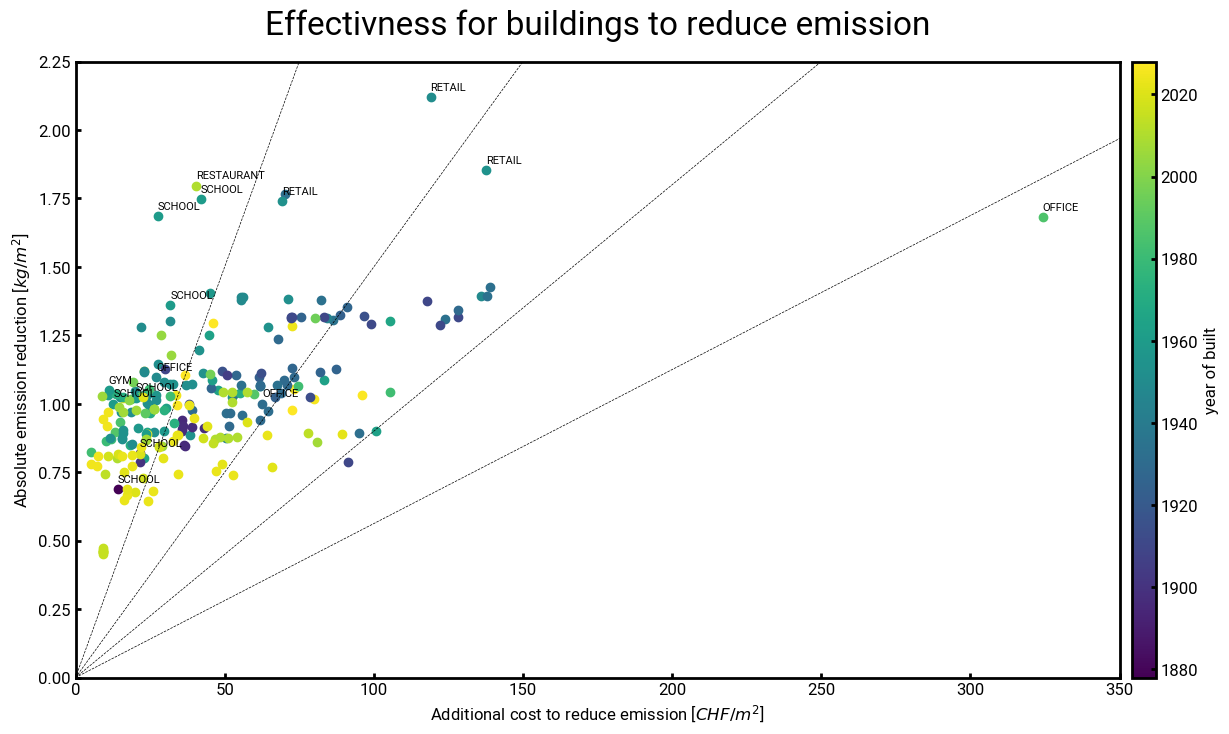

In [45]:
for building_name in df_tech_cap.index.get_level_values('building').unique():
    # get the df_pareto for this building
    df_pareto = df_tech_cap.loc[building_name]
    # the first point is emission minimal, thus cost maximal; 
    # last one is cost minimal, thus emission maximal
    # the slope defines how hard it is to reduce emission when sliding from cost minimal to emission minimal
    y1 = df_pareto['cost'].iloc[0]
    y2 = df_pareto['cost'].iloc[3]
    x1 = df_pareto['emission'].iloc[0]
    x2 = df_pareto['emission'].iloc[3]
    emission_reduction_absolute = x2-x1 # percentage of emission reduction
    cost_increase_absolute = y1-y2 # absolute cost increase
    # label the points with building name next to the points
    building_year = zone_df.loc[building_name, 'YEAR']
    # building_area = zone_df.loc[building_name, 'area'] * zone_df.loc[building_name, 'floors_ag']
    building_color = colormap(year_norm(building_year))
    # find building typology 
    plt.scatter(cost_increase_absolute, emission_reduction_absolute, label=building_name, marker='o', color=building_color)
    # annotate the building name next to the point
    if zone_df.loc[building_name, 'typology_1ST_USE'] not in ['SINGLE_RES', 'MULTI_RES']:
        plt.annotate(zone_df.loc[building_name, 'typology_1ST_USE'], (cost_increase_absolute, emission_reduction_absolute), 
                     fontsize=8, xytext=(0, 5), textcoords='offset points', ha='left')
    
plt.ylabel('Absolute emission reduction [$kg/m^2$]')
plt.xlabel('Additional cost to reduce emission [$CHF/m^2$]')
plt.xlim(0, 350)
plt.ylim(0, 2.25)
# plot a line from (0,0) to (100, 1) and extend to the right
plt.plot([0, 75], [0, 2.25], color='k', linestyle='--', linewidth=0.5)
plt.plot([0, 150], [0, 2.25], color='k', linestyle='--', linewidth=0.5)
plt.plot([0, 250], [0, 2.25], color='k', linestyle='--', linewidth=0.5)
plt.plot([0, 400], [0, 2.25], color='k', linestyle='--', linewidth=0.5)

# plot a horizontal line at 800
# plt.axhline(y=900, color='k', linestyle='--', linewidth=0.5)
# plt.axhline(y=530, color='k', linestyle='--', linewidth=0.5)
plt.title('Effectivness for buildings to reduce emission', fontsize=24)

# again, plot a colorbar next to the plot, with the same height as the plot box
cax = plt.axes([0.96, 0.11, 0.02, 0.77])
cbar = ColorbarBase(cax, cmap=colormap, norm=year_norm)
# label the building year on the left of the colorbar
cbar.ax.set_ylabel('year of built')

plt.savefig(r'C:\Users\wangy\polybox - Yiqiao Wang (yiqwang@student.ethz.ch)@polybox.ethz.ch\Final Report\Graphics\difficulty_absolute_{}.pdf'.format(store_folder[9:]), dpi=300, bbox_inches='tight')
plt.show()

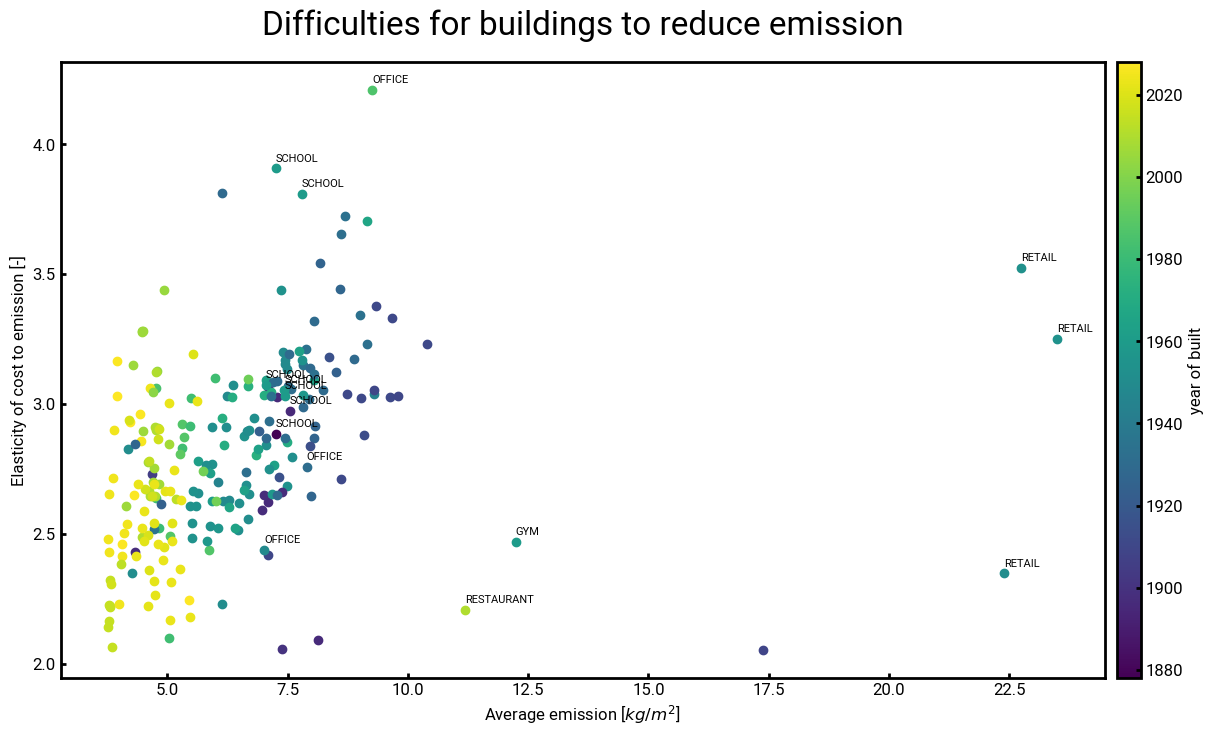

In [53]:
for building_name in df_tech_cap.index.get_level_values('building').unique():
    # get the df_pareto for this building
    df_pareto = df_tech_cap.loc[building_name]
    # the first point is emission minimal, thus cost maximal; 
    # last one is cost minimal, thus emission maximal
    # the slope defines how hard it is to reduce emission when sliding from cost minimal to emission minimal
    y1 = df_pareto['cost'].iloc[1]
    y2 = df_pareto['cost'].iloc[4]
    x1 = df_pareto['emission'].iloc[1]
    x2 = df_pareto['emission'].iloc[4]
    slope = -(y2-y1)/(x2-x1)
    average_emission = (df_pareto['emission'].iloc[-3] + df_pareto['emission'].iloc[1]) / 2
    # label the points with building name next to the points
    building_year = zone_df.loc[building_name, 'YEAR']
    # building_area = zone_df.loc[building_name, 'area'] * zone_df.loc[building_name, 'floors_ag']
    building_color = colormap(year_norm(building_year))
    # find building typology 
    plt.scatter(average_emission, slope, label=building_name, marker='o', color=building_color)
    # annotate the building name next to the point
    if zone_df.loc[building_name, 'typology_1ST_USE'] not in ['SINGLE_RES', 'MULTI_RES']:
        plt.annotate(zone_df.loc[building_name, 'typology_1ST_USE'], (average_emission, slope), 
                     fontsize=8, xytext=(0, 5), textcoords='offset points', ha='left')
    
plt.ylabel('Elasticity of cost to emission [-]')
plt.xlabel('Average emission [$kg/m^2$]')
# plt.xlim(3, 26)
# plt.ylim(1.8, 4.9)
# plot a horizontal line at 800
# plt.axhline(y=900, color='k', linestyle='--', linewidth=0.5)
# plt.axhline(y=530, color='k', linestyle='--', linewidth=0.5)
plt.title('Difficulties for buildings to reduce emission', fontsize=24)

# again, plot a colorbar next to the plot, with the same height as the plot box
cax = plt.axes([0.96, 0.11, 0.02, 0.77])
cbar = ColorbarBase(cax, cmap=colormap, norm=year_norm)
# label the building year on the left of the colorbar
cbar.ax.set_ylabel('year of built')

plt.savefig(r'C:\Users\wangy\polybox - Yiqiao Wang (yiqwang@student.ethz.ch)@polybox.ethz.ch\Final Report\Graphics\ParetoFront_elasticity_{}.pdf'.format(store_folder[9:]), dpi=300, bbox_inches='tight')
plt.show()

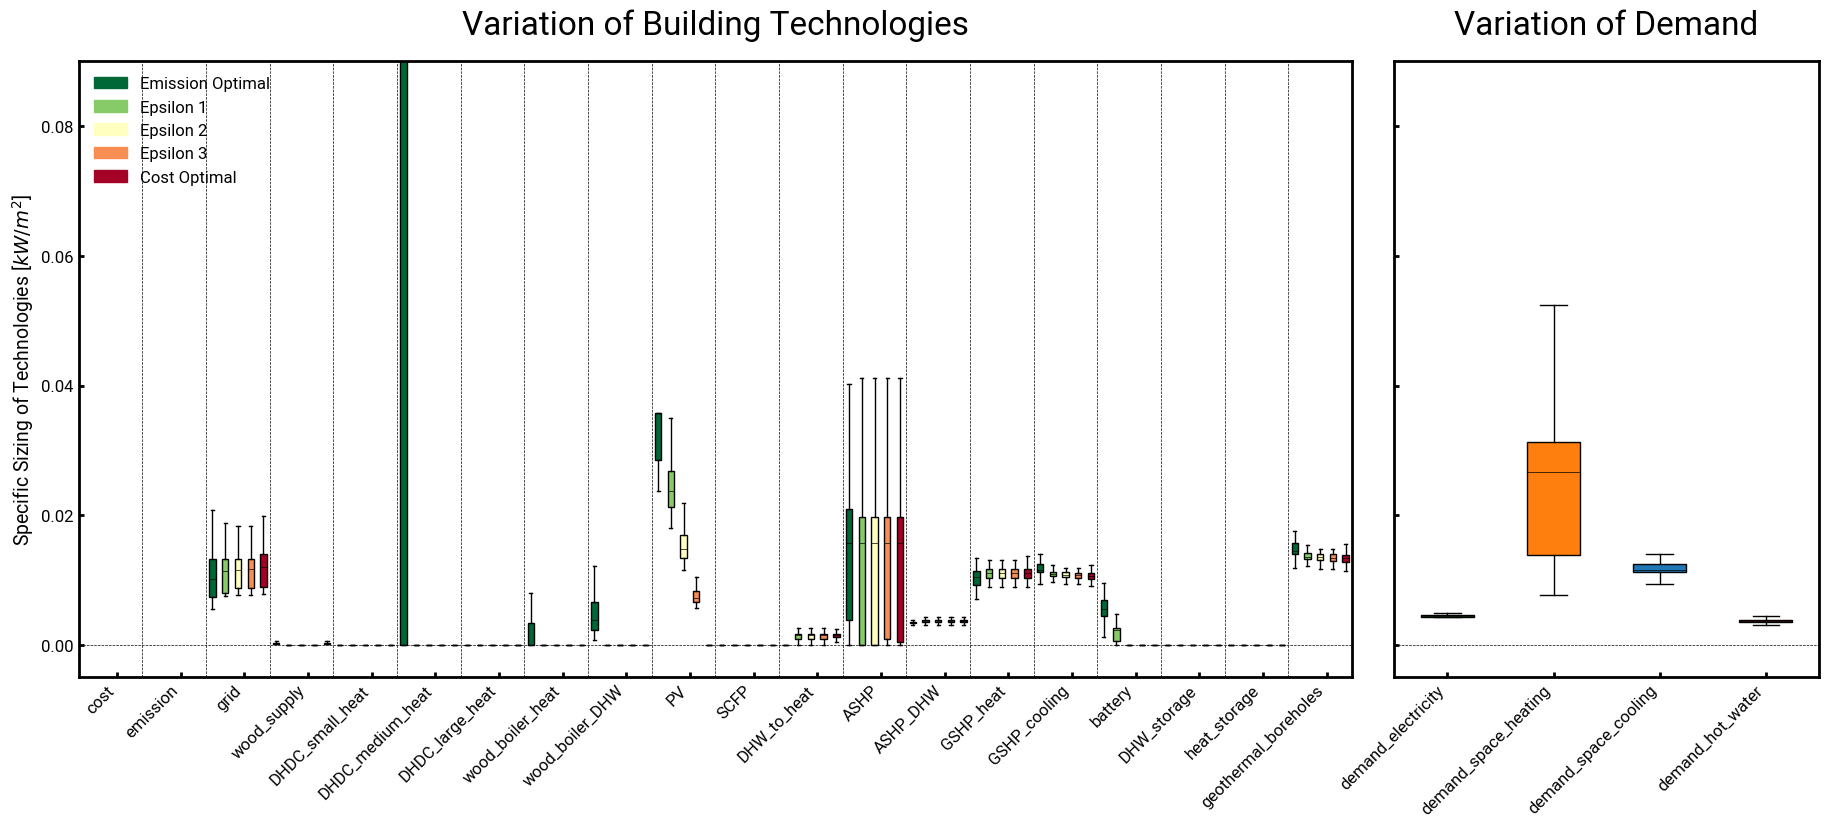

In [25]:
# Separate the demand technologies
df_demand_tech = df_tech_cap[df_tech_cap.columns[-4:]]
df_supply_tech = df_tech_cap[df_tech_cap.columns[:-4]]

# Create a figure with two subplots side by side, with a shared y-axis and width ratio of 3:1
fig, axs = plt.subplots(1, 2, sharey=True,figsize=(20, 8), gridspec_kw={'width_ratios': [3, 1]})

# Boxplot without outliers and with a custom hatch pattern
boxprops = dict(linestyle='-', linewidth=1, color='k')  # Custom box properties
medianprops = dict(linestyle='-', linewidth=0.5, color='k')  # Custom median properties

# Create a color map for the five epsilon cuts
cmap = plt.cm.get_cmap('RdYlGn', 5)# 5 distinct colors for 5 epsilon cuts
# reverse the color map so that the emission optimal is green
cmap = cmap.reversed()

# Create a boxplot for each technology
for i, tech in enumerate(df_supply_tech.columns):
    # Get the data for the current technology
    tech_data = df_supply_tech[tech].values.reshape(-1, 5)  # Reshape the data to have 5 rows for each technology
    bp = axs[0].boxplot(tech_data, positions=np.arange(i*5, i*5+5), patch_artist=True, showfliers=False, boxprops=boxprops, medianprops=medianprops)

    # Fill each box with a color according to its epsilon cut
    for j, box in enumerate(bp['boxes']):
        box.set(facecolor=cmap(j))

# Define your colors for the demand technologies
demand_colors = ['tab:green', 'tab:orange', 'tab:blue', 'tab:red']

# Create a boxplot for each demand technology, but only one box per technology
for i, tech in enumerate(df_demand_tech.columns):
    # calculate the mean of each technology in five epsilon cuts
    tech_data = df_demand_tech[tech].values.reshape(-1, 5).mean(axis=1)
    bp = axs[1].boxplot(tech_data, positions=[i], patch_artist=True, showfliers=False, boxprops=boxprops, medianprops=medianprops, widths=0.5)  # Set position to a single value and adjust the width
    # Fill each box with a color according to its epsilon cut
    for j, box in enumerate(bp['boxes']):
        box.set(facecolor=demand_colors[i])

# Set the x-axis labels to the technology names
axs[0].set_xticks(np.arange(2.5, len(df_supply_tech.columns)*5, 5))  # Set x-ticks to the middle box of each technology group
axs[0].set_xticklabels(df_supply_tech.columns, rotation=45)

# Align the x-axis labels to the right
for label in axs[0].get_xticklabels():
    label.set_horizontalalignment('right')

# Draw vertical lines to separate the technologies inbetween the boundary boxes, not on the box
for i in range(5, len(df_supply_tech.columns)*5, 5):
    axs[0].axvline(x=i-0.5, color='k', linestyle='--', linewidth=0.5)  # Subtract 0.5 from the x position

# set the second subplot's x axis to be the same as the first one, but only one box per technology
axs[1].set_xticks(range(len(df_demand_tech.columns)))  # Set x-ticks to the middle box of each technology group
axs[1].set_xticklabels(df_demand_tech.columns, rotation=45)

for label in axs[1].get_xticklabels():
    label.set_horizontalalignment('right')
# Set the title and axis labels
axs[0].set_title('Variation of Building Technologies', fontsize=24)
axs[1].set_title('Variation of Demand', fontsize=24)
axs[0].set_ylabel('Specific Sizing of Technologies [$kW/m^2$]', fontsize=14)

# Create a custom legend for the epsilon cuts
ls_epsilon_cut = ['Emission Optimal', 'Epsilon 1', 'Epsilon 2', 'Epsilon 3', 'Cost Optimal']
legend_patches = [mpatches.Patch(color=cmap(i), label=ls_epsilon_cut[i]) for i in range(5)]
axs[0].legend(handles=legend_patches, loc='upper left')

# print a horizontal line at 0 for both subplots
axs[0].axhline(y=0, color='k', linestyle='--', linewidth=0.5)
axs[1].axhline(y=0, color='k', linestyle='--', linewidth=0.5)

# Set the y-axis limits
axs[0].set_ylim(-0.005, 0.09)
# make the two plots a bit closer
plt.subplots_adjust(wspace=0.05)
# Tight layout to adjust padding
# plt.tight_layout()

# plt.savefig(r'C:\Users\wangy\polybox - Yiqiao Wang (yiqwang@student.ethz.ch)@polybox.ethz.ch\Final Report\Graphics\Variation_{}.pdf'.format(store_folder[9:]), dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

In [16]:
# optimize once for building B302030807
model = get_building_model(building_name='B302030807', building_scenario_folder=scenario_folder, 
                           yaml_path='./data/technology/techs_plot8.yml', store_folder='./result_site_specific_2',
                           building_status=zone_df.loc['B302030807'], flatten_spikes=True, flatten_percentile=0.98, to_lp=False, to_yaml=False, emission_constraint=None)
model.run()

the area of building B302030807 is 273.51458448111305 m2
{'co2': 0, 'monetary': 1}


In [ ]:
model.inputs.cost_purchase.to_pandas().dropna(axis=1)

In [ ]:
model.inputs.cost_energy_cap.to_pandas().dropna(axis=1)

In [ ]:
model.plot.timeseries()

In [134]:
model.results

<xarray.Dataset>
Dimensions:                                 (loc_techs: 18,
                                             loc_tech_carriers_prod: 16,
                                             timesteps: 1460,
                                             loc_tech_carriers_con: 15,
                                             costs: 2, loc_techs_cost: 14,
                                             loc_techs_area: 2,
                                             ...
                                             loc_techs_investment_cost: 12,
                                             loc_techs_purchase: 6,
                                             loc_techs_cost_investment_constraint: 12,
                                             loc_carriers_system_balance_constraint: 6,
                                             loc_techs_balance_demand_constraint: 4,
                                             carriers: 6, techs: 25)
Coordinates: (12/17)
  * techs                                   (techs) object 'ASHP' ... 'wood_s...
  * carriers                                (carriers) object 'DHW' ... 'wood'
  * costs                                   (costs) object 'co2' 'monetary'
  * loc_carriers_system_balance_constraint  (loc_carriers_system_balance_constraint) object ...
  * loc_tech_carriers_con                   (loc_tech_carriers_con) object 'B...
  * loc_tech_carriers_export                (loc_tech_carriers_export) object ...
    ...                                      ...
  * loc_techs_cost_investment_constraint    (loc_techs_cost_investment_constraint) object ...
  * loc_techs_investment_cost               (loc_techs_investment_cost) object ...
  * loc_techs_om_cost                       (loc_techs_om_cost) object 'B3020...
  * loc_techs_purchase                      (loc_techs_purchase) object 'B302...
  * loc_techs_store                         (loc_techs_store) object 'B302030...
  * timesteps                               (timesteps) datetime64[ns] 2050-0...
Data variables: (12/19)
    energy_cap                              (loc_techs) float64 67.35 ... 23.63
    carrier_prod                            (loc_tech_carriers_prod, timesteps) float64 ...
    carrier_con                             (loc_tech_carriers_con, timesteps) float64 ...
    cost                                    (costs, loc_techs_cost) float64 7...
    resource_area                           (loc_techs_area) float64 273.5 0.0
    storage_cap                             (loc_techs_store) float64 0.0 ......
    ...                                      ...
    system_balance                          (loc_carriers_system_balance_constraint, timesteps) float64 ...
    required_resource                       (loc_techs_balance_demand_constraint, timesteps) float64 ...
    capacity_factor                         (timesteps, loc_tech_carriers_prod) float64 ...
    systemwide_capacity_factor              (carriers, techs) float64 0.0 ......
    systemwide_levelised_cost               (carriers, costs, techs) float64 ...
    total_levelised_cost                    (carriers, costs) float64 0.1722 ...
Attributes:
    termination_condition:     optimal
    objective_function_value:  8017.432229433613
    solution_time:             9.57991
    time_finished:             2023-12-12 01:18:24
    calliope_version:          0.6.10
    applied_overrides:         
    scenario:                  None
    defaults:                  carrier_ratios:\ncharge_rate:\nenergy_cap_per_...
    allow_operate_mode:        1
    model_config:              calliope_version: 0.6.10\nname: building in pl...
    run_config:                backend: pyomo\nbigM: 100000000.0\ncyclic_stor...

the building with the largest borehole_prod is B302030807 with a value of 327.362949125638


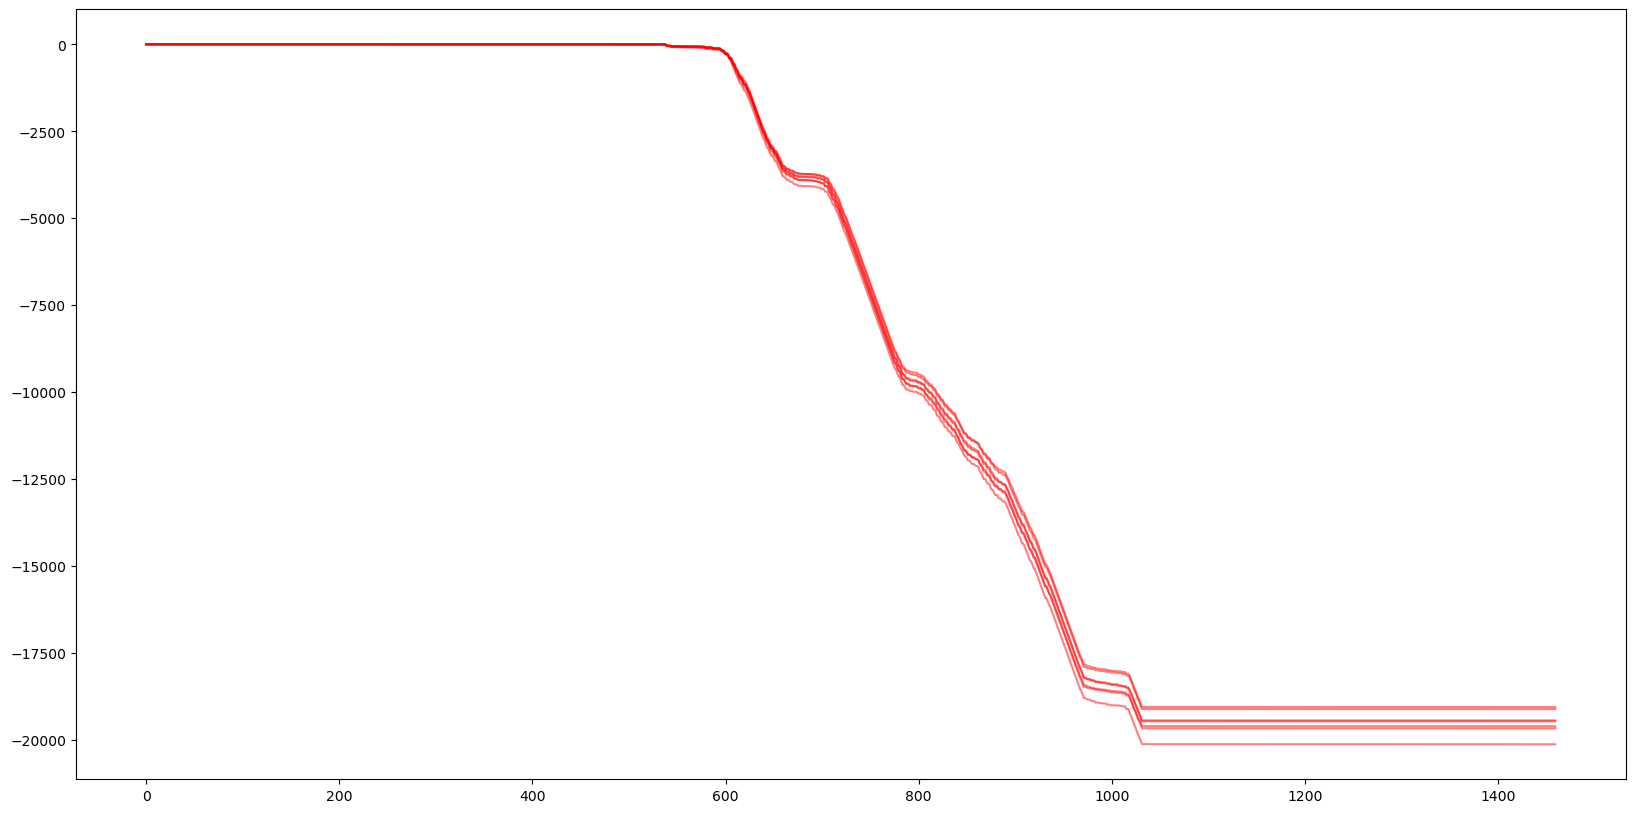

In [63]:
# plot for each building, the borehole cumulative energy flow
# set plot size
plt.figure(figsize=(20, 10))
# set x axis to be the timestep, from 0 to 8760/4
x = range(0, 1460)
# set colormap to be summer
# plt.set_cmap('summer')
borehole_prod_max = 0
borehole_prod_max_idx = ''
for idx, row in energy_cap_df.iterrows():
    model = calliope.read_netcdf(f'./result_site_specific_2/{idx}.nc')
    # try to find the borehole operation data, but if there's no borehole, there will be an error, so use try
    try:
        borehole_prod = model.get_formatted_array('carrier_prod').sel(techs='geothermal_boreholes', 
                                                              carriers='geothermal_storage', 
                                                              locs=idx).to_pandas()
        borehole_con = model.get_formatted_array('carrier_con').sel(techs='geothermal_boreholes',
                                                                    carriers='geothermal_storage',
                                                                    locs=idx).to_pandas()
    except:
        continue
    plt.plot(x, borehole_prod.cumsum()+borehole_con.cumsum(), color='red', alpha=0.5)
    # plt.plot(x, borehole_con.cumsum(), color='blue', alpha=0.5)
    
    # find the largest value of borehole_prod in this loop and report the index of it
    if borehole_prod.max() > borehole_prod_max:
        borehole_prod_max = borehole_prod.max()
        borehole_prod_max_idx = idx
    
print(f'the building with the largest borehole_prod is {borehole_prod_max_idx} with a value of {borehole_prod_max}')
# show the plot
plt.show()

## test for one building

In [18]:
building = Building('B302030807', scenario_folder)
building.flatten_spikes_demand(percentile=0.98) # flatten the demand spikes
dict_timeseries_df = {'demand_el': building.app,
                      'demand_sh': building.sh,
                      'demand_dhw': building.dhw,
                      'demand_sc': building.sc,
                      'supply_PV': building.pv_intensity,
                      'supply_PVT_e': building.pvt_e_intensity,
                      'supply_PVT_h': building.pvt_h_relative_intensity,
                      'supply_SCFP': building.scfp_intensity
                      }
row = zone_df.loc[building.name]
# modify the building_specific_config to match the building's status
building_specific_config: calliope.AttrDict = calliope.AttrDict.from_yaml('./data/technology/techs_plot8.yml')
building_specific_config.set_key(key='locations.Building.available_area', value=building.area)
print('the area of building '+building.name+' is '+str(building.area)+' m2')
building_sub_dict = building_specific_config['locations'].pop('Building')
building_specific_config['locations'][building.name] = building_sub_dict

# update geothermal storage max capacity
building_specific_config.set_key(key=f'locations.{building.name}.techs.geothermal_boreholes.constraints.energy_cap_max',
                                 value=(building.area+400)*0.1) # assume 100W/m2 max yield
# if building is not in district heating area, delete the district heating technologies keys
if not row['is_disheat']:
    building_specific_config.del_key(f'locations.{building.name}.techs.DHDC_small_heat')
    building_specific_config.del_key(f'locations.{building.name}.techs.DHDC_medium_heat')
    building_specific_config.del_key(f'locations.{building.name}.techs.DHDC_large_heat')

# if building is already equipped with GSHP, set the GSHP purchase cost to 0
if row['already_GSHP']:
    building_specific_config.set_key(f'locations.{building.name}.techs.GSHP_heat.costs.monetary.purchase', 0)
    building_specific_config.set_key(f'locations.{building.name}.techs.GSHP_heat.costs.monetary.energy_cap', 0)

# if building is already equipped with ASHP, set the ASHP purchase cost to 0
if row['already_ASHP']:
    building_specific_config.set_key(f'locations.{building.name}.techs.ASHP.costs.monetary.purchase', 0)
    building_specific_config.set_key(f'locations.{building.name}.techs.ASHP.costs.monetary.energy_cap', 0)

# if building is not rebuilt, set GSHP and ASHP costs higher
if not row['is_rebuilt']:
    if not row['already_GSHP']:
        building_specific_config.set_key(f'locations.{building.name}.techs.GSHP_heat.costs.monetary.purchase', 39934)
        building_specific_config.set_key(f'locations.{building.name}.techs.GSHP_heat.costs.monetary.energy_cap', 1316)
    if not row['already_ASHP']:
        building_specific_config.set_key(f'locations.{building.name}.techs.ASHP.costs.monetary.purchase', 18086)
        building_specific_config.set_key(f'locations.{building.name}.techs.ASHP.costs.monetary.energy_cap', 1360)

    # if building is not new, delete the GSHP technology keys
if not row['is_new']:
    building_specific_config.del_key(f'locations.{building.name}.techs.GSHP_heat')
    building_specific_config.del_key(f'locations.{building.name}.techs.GSHP_cooling')
    building_specific_config.del_key(f'locations.{building.name}.techs.geothermal_boreholes')

# # test: delete ASHP
# building_specific_config.del_key(f'locations.{building.name}.techs.ASHP')        

model = calliope.Model(building_specific_config, timeseries_dataframes=dict_timeseries_df)
# model.to_lp('./result_site_specific_2/'+building.name+'.lp')
model.run()
# model.save_commented_model_yaml('./result_site_specific_2/'+building.name+'.yaml')
# # save to result_per_building, which is a subfolder of current working directory
# model.to_netcdf(path='./result_site_specific_2/'+building.name+'.nc')
# # calculate how many percent of the buildings are done, including the current one and its name
# # calculate how many .nc files are in the subfolder, but some files are not .nc files, so len(os.listdir()) is not accurate
# number_of_nc_files = len(glob.glob('./result_site_specific_2/*.nc'))
# print('including '+building.name+', '+str(round(number_of_nc_files/len(zone_df.index)*100, 2))+'% of the buildings are done')

the area of building B302030807 is 273.51458448111305 m2


In [19]:
model_tech_cost = model.get_formatted_array('cost').sel(locs='B302030807').to_pandas().transpose()
model_energy_cap = model.get_formatted_array('energy_cap').to_pandas().iloc[0]

In [20]:
# model = calliope.read_netcdf('./result_site_specific_2/B302030807.nc')
model_geostore_prod = model.get_formatted_array('carrier_prod').sel(carriers='geothermal_storage', locs='B302030807').to_pandas().transpose()
model_geostore_con = model.get_formatted_array('carrier_con').sel(carriers='geothermal_storage', locs='B302030807').to_pandas().transpose()
model_geostore_all = model_geostore_prod.merge(model_geostore_con, left_index=True, right_index=True)

model_sh_prod = model.get_formatted_array('carrier_prod').sel(carriers='heat', locs='B302030807').to_pandas().transpose()
model_sh_con = model.get_formatted_array('carrier_con').sel(carriers='heat', locs='B302030807').to_pandas().transpose()
model_sh_all = model_sh_prod.merge(model_sh_con, left_index=True, right_index=True)

model_el_prod = model.get_formatted_array('carrier_prod').sel(carriers='electricity', locs='B302030807').to_pandas().transpose()
model_el_con = model.get_formatted_array('carrier_con').sel(carriers='electricity', locs='B302030807').to_pandas().transpose()
model_el_all = model_el_prod.merge(model_el_con, left_index=True, right_index=True)

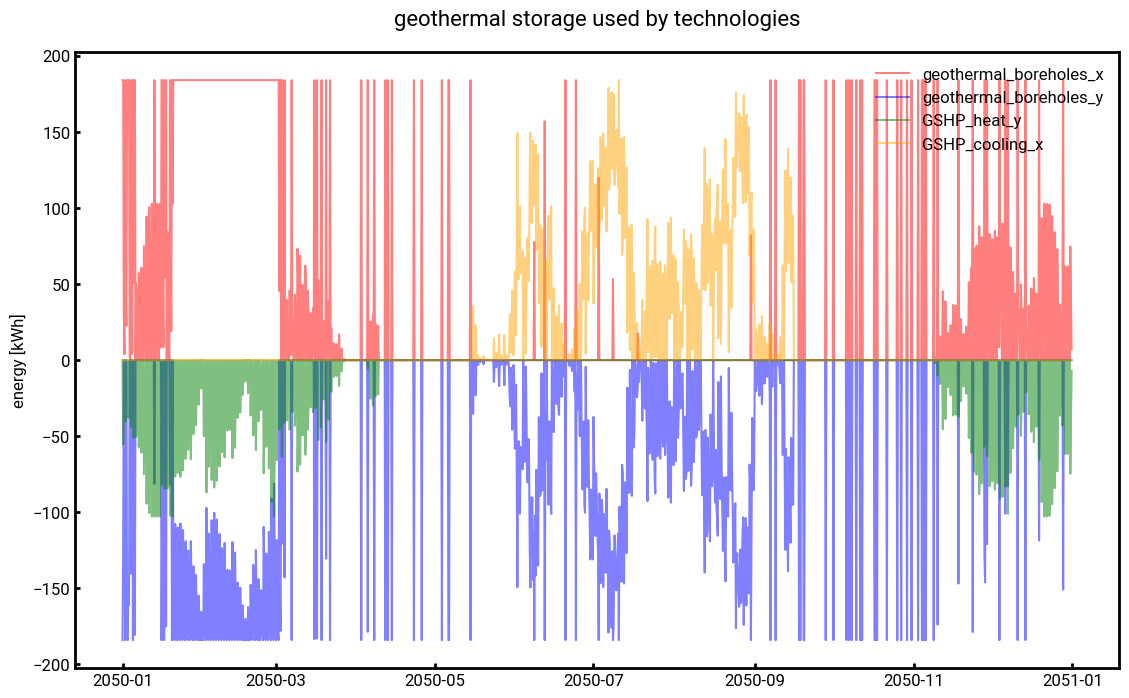

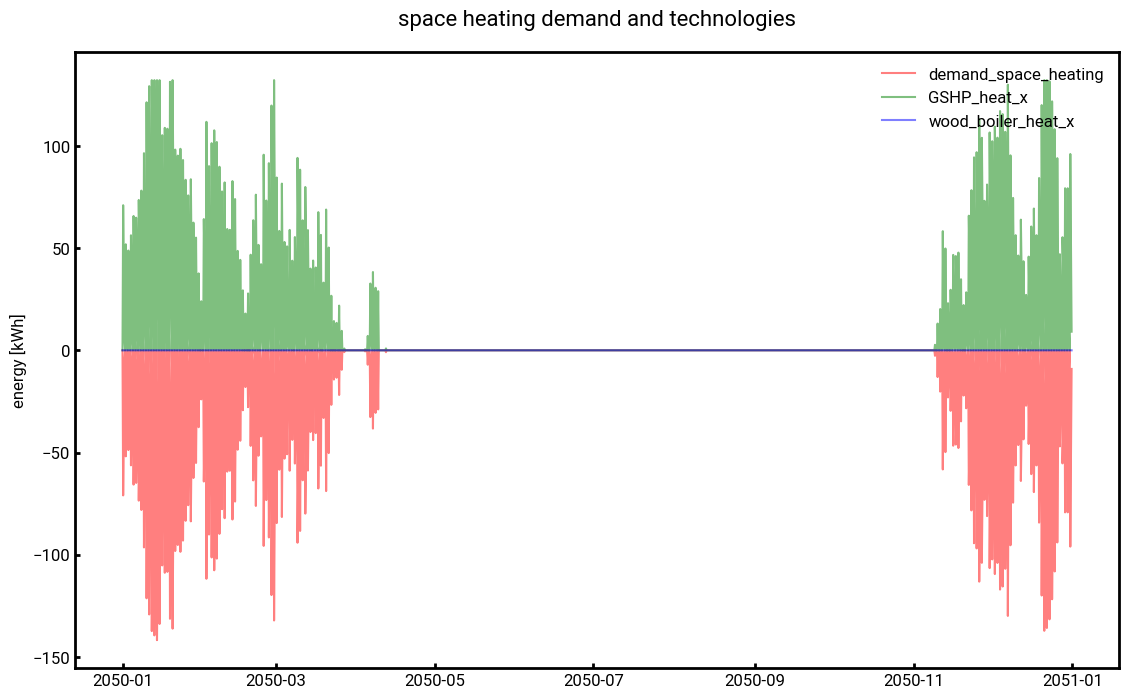

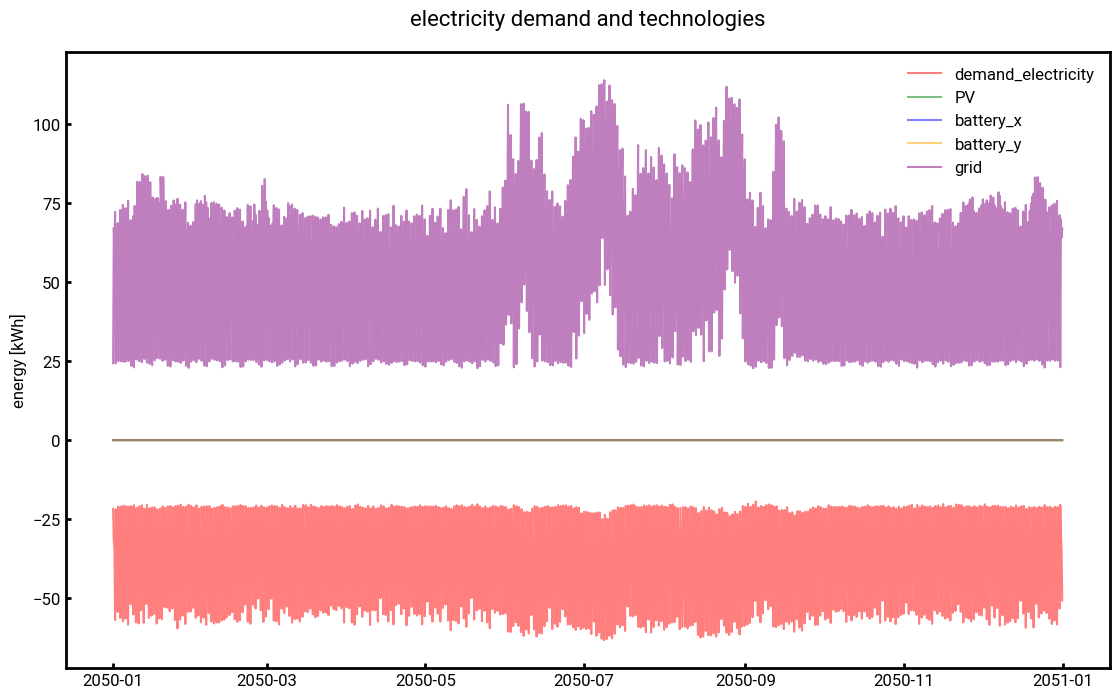

In [21]:
# plot the model_geostore_all, with x axis as timestep, and four ys: geothermal_boreholes_x, geothermal_boreholes_y, GSHP_heat_y, GSHP_cooling_x
plt.plot(model_geostore_all.index, model_geostore_all['geothermal_boreholes_x'], color='red', alpha=0.5)
plt.plot(model_geostore_all.index, model_geostore_all['geothermal_boreholes_y'], color='blue', alpha=0.5)
plt.plot(model_geostore_all.index, model_geostore_all['GSHP_heat_y'], color='green', alpha=0.5)
plt.plot(model_geostore_all.index, model_geostore_all['GSHP_cooling_x'], color='orange', alpha=0.5)
plt.legend(['geothermal_boreholes_x', 'geothermal_boreholes_y', 'GSHP_heat_y', 'GSHP_cooling_x'], loc='upper right')
plt.title('geothermal storage used by technologies')
plt.ylabel('energy [kWh]')
plt.show()

plt.plot(model_sh_all.index, model_sh_all['demand_space_heating'], color='red', alpha=0.5)
plt.plot(model_sh_all.index, model_sh_all['GSHP_heat_x'], color='green', alpha=0.5)
plt.plot(model_sh_all.index, model_sh_all['wood_boiler_heat_x'], color='blue', alpha=0.5)
plt.legend(['demand_space_heating', 'GSHP_heat_x', 'wood_boiler_heat_x'], loc='upper right')
plt.title('space heating demand and technologies')
plt.ylabel('energy [kWh]')
plt.show()

# plot in model_el_all, with x axis as timestep, and ys: PV, battery_x, battery_y, grid, GSHP_heat_y, GSHP_cooling_y
plt.plot(model_el_all.index, model_el_all['demand_electricity'], color='red', alpha=0.5)
plt.plot(model_el_all.index, model_el_all['PV'], color='green', alpha=0.5)
plt.plot(model_el_all.index, model_el_all['battery_x'], color='blue', alpha=0.5)
plt.plot(model_el_all.index, model_el_all['battery_y'], color='orange', alpha=0.5)
plt.plot(model_el_all.index, model_el_all['grid'], color='purple', alpha=0.5)
plt.legend(['demand_electricity', 'PV', 'battery_x', 'battery_y', 'grid'], loc='upper right')
plt.title('electricity demand and technologies')
plt.ylabel('energy [kWh]')
plt.show()